# Task 3: Decision trees and random forests


### 1. Introduction & objectives

In this assignment, we will be working towards creating a transparent, whitebox classification model by leveraging decision trees and get familiar with improving our classification models performance through the use of random forests.

#### Decision trees
Decision trees goal is to predict the value of a target variable by learning simple decision based rules extracted from a given dataset. The strength of a decision tree comes from ease of understanding and interpretation of the decision paths in a tree. The decision tree also has little need for data preparation, where others need data to be normalized or dummy variables need to be created or null values dropped. One of the drawbacks of the decision tree is that there can be many nearly as good branching criteria and the best of the might be chosen with a small margin. However there is a solution to this problem which we will introduce on the next section.

[Course Github](https://github.com/vesavvo/dkko/blob/main/Random_forests.ipynb)

[scikit-learn.org](https://scikit-learn.org/stable/modules/tree.html)

#### Random forests
Random forests are formed by creating a number of decision trees during the training phase. A random forest is a collection of a user-set amount of decision trees with varying classification methods. These decision trees are to vote on the classification outcome for a given observation

[Course Github](https://github.com/vesavvo/dkko/blob/main/Random_forests.ipynb)

#### Our aim
With these tools and the [dataset](https://archive.ics.uci.edu/dataset/327/phishing+websites) from UC Irvine machine learning repository we aim to make a classifier that is able to distinguish between phishing sites and legitimate sites with fair accuracy.

### 2. Understanding the phishing technique
The dataset has 11055 instances each with 30 features and one target. The dataset is built with features like url_length, having_at_symbol, favicon. These features are then evaluated from -1, 0 and 1 where -1 = legitimate 0 = suspicious and finally 1 = phishing site.

#### Examples of features and their numbering convention

The full explanation for all the features and their variable meaning comes in the datasets zip file.

As we cannot intuitively read from the data sets what each number value signifies we need to refer to the documentation provided in the [datasets](https://archive.ics.uci.edu/dataset/327/phishing+websites) files.


---
#### URL length
* url_length: if the URL is equal or greater than 54 but shorter than or equal to 75.
    * URL length < 54 -> legitimate (-1)
    * else if URL_length >= 54 and =< 75 -> suspicious (0)
    * otherwise -> feature = phishing (1)

The long URL is seen as an attempt to hide the suspicious parts of the URL near the end so it won't be seen by the user as easily.

---
#### having "@" symbol
* having_at_symbol: 
    * Has "@" -> Phishing (1)
    * Otherwise -> Legitimate (-1)

The @ symbol is immediately flagged as a phishing sites feature as the "@" is used to make the browser ignore everything preceding the "@" symbol.

---
#### favicon
* favicon
    * Favicon loaded from external domain -> phishing (0)
    * Otherwise -> legitimate (-1)

    
Favicon is used in the browser to enhance the visual identity of their services. If the sites favicon is loaded from another domain than the one shown in the address bar the website is likely to be considered as a phishing attempt.

When constructing the decision trees we will be able to take a look inside the decision trees processes.

---

### 2.1 Importing the libraries and dataset

We will start by importing the necessary libraries and the dataset.

In [116]:
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [117]:
# Fetch the dataset
phishing = fetch_ucirepo(id=327)

# Data and targets (as pandas dataframes)
features = phishing.data.features
targets = phishing.data.targets

# We need to make copies of the dataframes to avoid modifying the original data
features = features.copy()
targets = targets.copy()

#### 2.2 Summary of variables

Let's check the first few rows of the dataset to understand the variables and their types

In [118]:
print("Features:")
features.head()

Features:


,having_ip_address,url_length,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,favicon,...,rightclick,popupwindow,iframe,age_of_domain,dnsrecord,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,1,-1,-1,-1,-1,1,1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,1,-1,-1,0,-1,1,1,1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,1,-1,1,-1,1,0,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,1,-1,-1,1,-1,1,-1,1
4,1,0,-1,1,1,-1,1,1,-1,1,...,1,-1,1,-1,-1,0,-1,1,1,1


In [128]:
print("Targets:")
targets.head()

Targets:


,result
0,-1
1,-1
2,-1
3,-1
4,1


#### 2.3 Data Preprocessing

According to the UC Irvine repository, the dataset has no missing values. However, we will check for missing values to confirm this.

In [120]:
# Check for missing values
missing_values = features.isnull().sum()
missing_values

having_ip_address             0
url_length                    0
shortining_service            0
having_at_symbol              0
double_slash_redirecting      0
prefix_suffix                 0
having_sub_domain             0
sslfinal_state                0
domain_registration_length    0
favicon                       0
port                          0
https_token                   0
request_url                   0
url_of_anchor                 0
links_in_tags                 0
sfh                           0
submitting_to_email           0
abnormal_url                  0
redirect                      0
on_mouseover                  0
rightclick                    0
popupwindow                   0
iframe                        0
age_of_domain                 0
dnsrecord                     0
web_traffic                   0
page_rank                     0
google_index                  0
links_pointing_to_page        0
statistical_report            0
dtype: int64

As we can see, there are no missing values in the datates. We can proceed with splitting the data into training and testing sets.

### 3. Data preparation

#### 3.1 Splitting the data into training and testing sets

We will split the dataset into training and testing sets to evaluate the performance of the model. We will use 80% of the data for training and 20% for testing.

In [121]:
# Split the data into training and testing sets (80% training, 20% testing)
features_train, features_test, targets_train, targets_test = train_test_split(features, targets, test_size=0.2, random_state=42)

The data has been successfully split into training and testing sets. We can now proceed with building the decision tree model.

#### 3.2 Visualizing the data

Unfortunately, there is no easy way to visualize the data due to the features having arbitrary values which are not vindicative of anything concrete. However, we can visualize the decision tree model after training to understand how the model makes decisions.

### 4. Decision Tree

#### 4.1 Creating the decision tree model

We will create a decision tree model using the `DecisionTreeClassifier` class from scikit-learn.

In [122]:
# Create the model
model = DecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(features_train, targets_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

The decision tree model has been successfully trained on the training data. We can now evaluate the model's performance on the testing data.

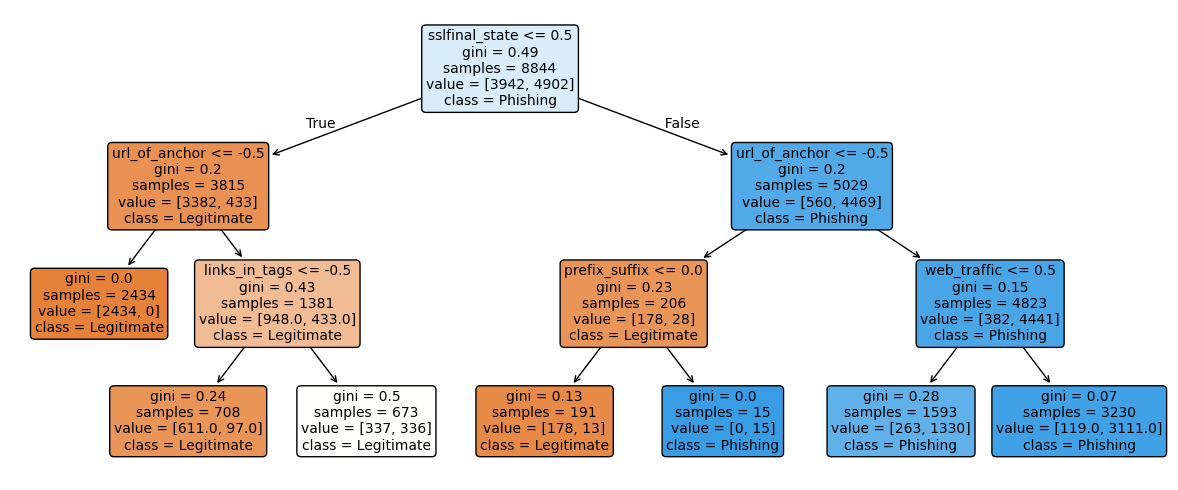

In [123]:
# Set the size of the plot
plt.figure(figsize=(12, 5))

# Plot the decision tree
plot_tree(
    model,
    feature_names=features.columns,
    class_names=["Legitimate", "Phishing"],
    filled=True,
    rounded=True,
    proportion=False,
    fontsize=10,
    precision=2)

# Show the plot with a tight layout
plt.tight_layout()
plt.show()

#### Step-by-step Instructions for determining website legitimacy

1. First check the SSL certificate of the website. If it is valid, the website is most likely legitimate.
2. If the SSL certificate is invalid, check the Anchor of the URL. If the anchor is empty or differs from the domain, the website is most likely a phishing site.
3. If the anchor is the same as the domain, check the web traffic. If the web traffic is low, the website is most likely a phishing site.
4. However, if the anchor is not the same as the domain, check the prefix and suffix of the URL. If the prefix is "https" and the suffix is ".com", and the URL doesn't contain "-" symbol, or any other suspicious symbol in the address, the website is most likely legitimate.

Here is a good example of a possible phishing website:

http://www.totally_legit-com.suspicious-hosting-service0010.com

#### 4.2 Evaluating the decision tree model

We will evaluate the decision tree model on the testing data using accuracy as the evaluation metric. We will also calculate the confusion matrix to understand the model's performance in more detail.

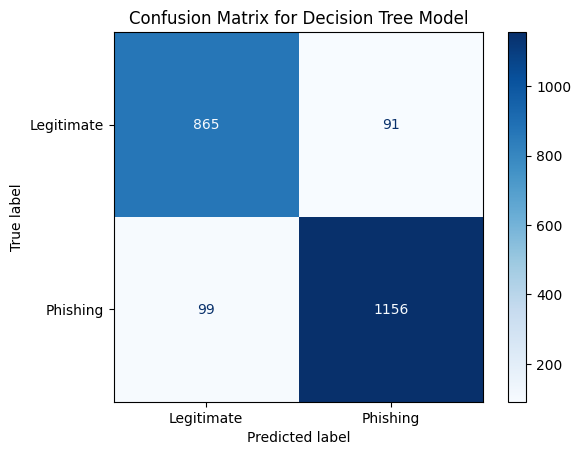

Accuracy of the Decision Tree Model: 91.41%


In [124]:
# Predict the target values
targets_pred = model.predict(features_test)

# Plot the confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix(targets_test, targets_pred), display_labels=["Legitimate", "Phishing"])

# Set the color of the plot to Blues
cmd.plot(cmap="Blues")

# Set the title of the plot and show it
plt.title("Confusion Matrix for Decision Tree Model")
plt.show()

# Calculate the accuracy of the model
accuracy = model.score(features_test, targets_test)
print(f"Accuracy of the Decision Tree Model: {accuracy * 100:.2f}%")

The confusion matrix shows the following results:
- True Positives (Model correctly predicted these as phishing sites): 865
- True Negatives (Model correctly predicted these aslegitimate sites): 1156
- False Positives (Model incorrectly predicted these as phishing sites): 91
- False Negatives (Model incorrectly predicted these as legitimate sites): 99

From this we can conclude that the decision tree model has an accuracy of 91.41% on the testing data.

#### 4.3 Decision Tree Conclusion

The decision tree model has provided us with an accuracy of 91.41% on the testing data. The model is able to distinguish between phishing sites and legitimate sites with a high degree of accuracy. The decision tree visualization also provides us with insights into how the model makes decisions based on the features of the dataset.

### 5. Random Forest 

#### 5.1 Creating the random forest model

Let's create a random forest model using the `RandomForestClassifier` class from scikit-learn.


In [125]:
# Create the random forest model
rf_model = RandomForestClassifier(n_estimators=100, bootstrap=True, max_samples=0.7, max_features=0.75, max_depth=3, random_state=42)

# Train the model on the training data (we must use .values.ravel() on the targets to change the shape of the array)
rf_model.fit(features_train, targets_train.values.ravel())

RandomForestClassifier(max_depth=3, max_features=0.75, max_samples=0.7,
                       random_state=42)

The random forest model has been successfully trained on the training data. We can now evaluate the model's performance on the testing data.

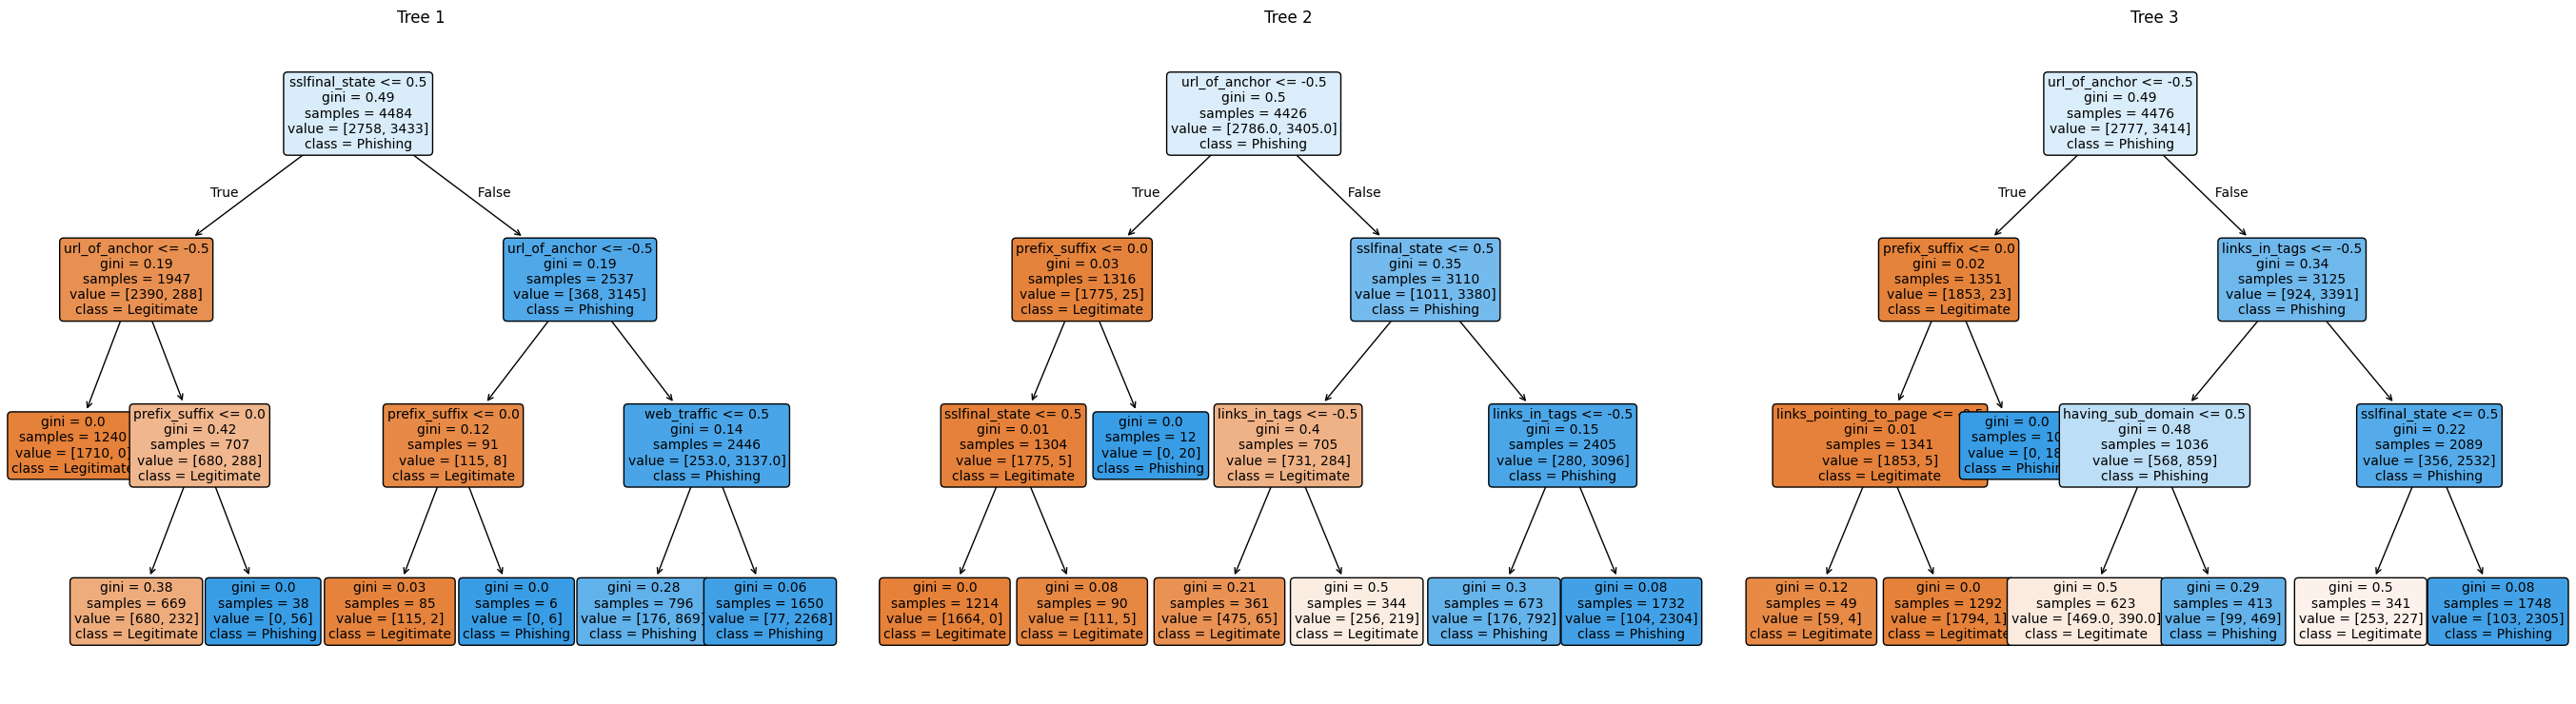

In [126]:
# Set the size of the figure
plt.figure(figsize=(27.5, 7.5))

# Number of trees in the forest
n_trees = 3

# Plot the trees in the random forest
for i in range(n_trees):
    plt.subplot(1, n_trees, i + 1)
    plot_tree(
        rf_model.estimators_[i],
        feature_names=features.columns,
        class_names=["Legitimate", "Phishing"],
        filled=True,
        rounded=True,
        proportion=False,
        fontsize=10,
        precision=2)
    plt.title(f"Tree {i + 1}")
    
# Show the plot with a tight layout
plt.tight_layout()
plt.show()

#### 5.2 Evaluating the random forest model

We will evaluate the random forest model on the testing data using accuracy as the evaluation metric. We will also calculate the confusion matrix to understand the model's performance in more detail.

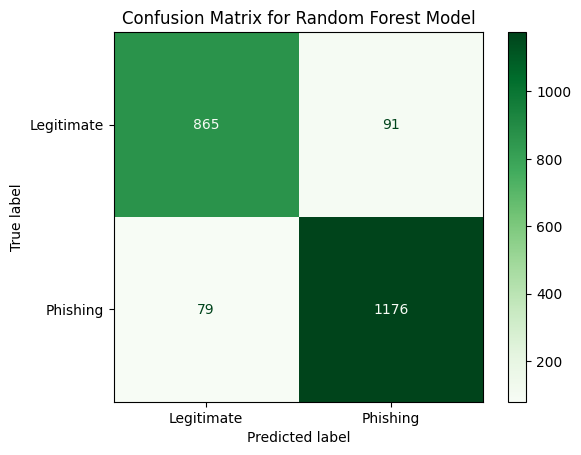

Accuracy of the Random Forest Model: 92.31%


In [127]:
# Predict the target values
rf_targets_pred = rf_model.predict(features_test)

# Plot the confusion matrix
rf_cmd = ConfusionMatrixDisplay(confusion_matrix(targets_test, rf_targets_pred), display_labels=["Legitimate", "Phishing"])

# Set the color of the plot to Greens
rf_cmd.plot(cmap="Greens")

# Set the title of the plot and show it
plt.title("Confusion Matrix for Random Forest Model")
plt.show()

# Calculate the accuracy of the model
rf_accuracy = rf_model.score(features_test, targets_test)
print(f"Accuracy of the Random Forest Model: {rf_accuracy * 100:.2f}%")

The confusion matrix shows the following results:
- True Positives (Model correctly predicted these as phishing sites): 865
- True Negatives (Model correctly predicted these as legitimate sites): 1176
- False Positives (Model incorrectly predicted these as phishing sites): 91
- False Negatives (Model incorrectly predicted these as legitimate sites): 79

From this we can conclude that the random forest model has an accuracy of 92.31% on the testing data.

#### 5.3 Random Forest Conclusion

The random forest model has provided us with an accuracy of 92.31% on the testing data. The model is able to distinguish between phishing sites and legitimate sites with a high degree of accuracy. The random forest model has outperformed the decision tree model in terms of accuracy. The random forest model is an ensemble of decision trees, which helps in improving the model's performance by reducing overfitting and increasing accuracy.

### 6. Conclusion

In this assignment, we have successfully built and evaluated a decision tree model and a random forest model to distinguish between phishing sites and legitimate sites. The decision tree model achieved an accuracy of 91.41% on the testing data, while the random forest model achieved an accuracy of 92.31%. The random forest model outperformed the decision tree model in terms of accuracy, which demonstrates the effectiveness of using an ensemble of decision trees to improve the model's performance. The decision tree and random forest models provide insights into how the models make decisions based on the features of the dataset. The decision tree model is transparent and easy to interpret, while the random forest model is more complex but provides higher accuracy. Overall, both models are effective in distinguishing between phishing sites and legitimate sites, and the random forest model is recommended for better accuracy and performance.